In [114]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from math import floor
from scipy.signal import convolve2d
import time

In [3]:
n = 2_000
A = np.random.randn(n, n)
for i in tqdm(range(10)):
    np.matmul(A, A)

100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


In [5]:
def load_img(fname, dirname='images/'):
    Im_PIL = Image.open(dirname + fname)
    return np.array(Im_PIL)

In [7]:
def gradient(u):
    m, n = u.shape
    grad_u = np.zeros((2, m, n))
    
    grad_u[0, :-1, :] = u[1:] - u[:-1]
    
    grad_u[1, :, :-1] = u[:, 1:] - u[:, :-1]
    
    return grad_u

In [9]:
def div(p):
    m, n = p.shape[1:]
    
    div_1 = np.zeros((m, n))
    div_1[:-1, :] = p[0, :-1, :]
    div_1[1:, :] -= p[0, :-1, :]
    
    div_2 = np.zeros((m, n))
    div_2[:, :-1] = p[1, :, :-1]
    div_2[:, 1:] -= p[1, :, :-1]
    
    return div_1 + div_2

In [11]:
def laplacian(u):
    return div(gradient(u))

In [13]:
def convergence_criteria(u0, u1, conv_crit):
    a = (np.linalg.norm(u1-u0)/np.linalg.norm(u0)) < conv_crit 
    return a 

In [15]:
def scalar_product(u, v):
    if u.ndim > 2:
        return np.sum(u * v, axis=0)
    else:
        return np.sum(u * v)

def norm(u):
    return np.sqrt(scalar_product(u, u))

In [17]:
def proxF1(x, h) : 
    y = x/(1+h)
    return(y)

In [19]:
def proxF2(x,h,f) :
    y = (x + h*f)/(1+h)
    return(y)

In [21]:
def proxF4(x,H):
    m,n = np.shape(x)
    prox4=np.zeros((m,n))
    for j in range(m):
        for i in range (n):
            if (x[j,i]>H[j,i]):
                prox4[j,i] = x[j,i]-H[j,i]
            elif (x[j,i]<-H[j,i]):
                prox4[j,i] = x[j,i]+H[j,i]
            else:
                prox4[j,i] = 0
    return prox4

In [23]:
def proj(z):
    if np.max(np.abs(z)>1):
        x = z[0]
        y = z[1]
        norm = np.sqrt(x**2 + y**2)
        x = x/norm
        y = y/norm
        z = np.stack((x,y))
    
    return z

In [25]:
def grad_proj(x,tau,K,h,conv_crit):
    n,m = x.shape
    z0 = np.ones((2,n,m))
    for i in range(K):
        grad_z = -2*gradient(div(z0)+x/h)
        z = proj(z0 - tau*grad_z)
        if convergence_criteria(z,z0,conv_crit) == True :
            break
        z0 = z
   
    return z

In [27]:
def proxF5(x,h,tau,K,conv_crit):
    z = np.copy(x)
    z = grad_proj(z,tau,K,h,conv_crit)
    y = x + h*div(z)
    return y

In [29]:
Im = load_img('cameraman.png')

In [31]:
def grad_F (lamb,x,f):
    return 2*lamb*(x-f)

# FISTA

In [34]:
def FFB(f,h,prox,tau,K,conv_crit):
    temps = time.time()
    x0 = np.copy(f)
    t0 = 1
    y0 = x0
    tab = np.zeros(K)
    tab2 = np.zeros(K)
    for i in tqdm(range(K)):
        yy = y0-h*grad_F(lamb,y0,f)
        x1 = prox(yy,h,tau,K,conv_crit)
        t1 = (1+np.sqrt(1+4*t0**2))/2
        y1 = x1 + ((t0-1)/t1)*(x1-x0)
        
        tab[i] = np.linalg.norm(x1-x0)
        tab2[i] = lamb * np.linalg.norm(f - y1) + np.sum(np.abs(gradient(y1)))
        x0 = x1
        t0 = t1
        y0 = y1
    
    print("Temps de calcul FISTA :",time.time() - temps,"s")
    return x1,tab, tab2

In [36]:
def add_gaussian_noise(I, s):
    m, n = I.shape
    
    I_out = I + s * np.random.randn(m, n)
    
    return I_out

In [38]:
img_bruit = add_gaussian_noise(Im,30)

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Temps de calcul FISTA : 47.95435094833374 s


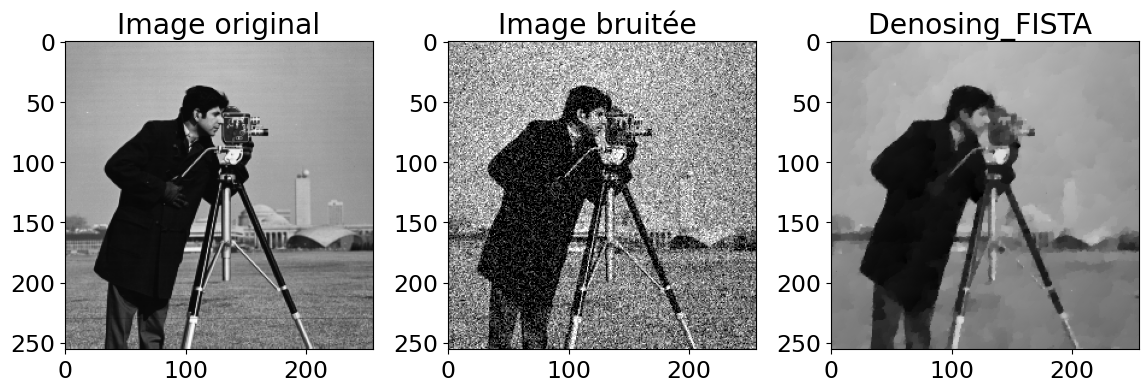

In [158]:
conv_crit = 0.01
lamb = 0.01
bounds = {'vmin': 0, 'vmax': 255}
denoised_image_fista, tab, tab2=FFB(add_gaussian_noise(Im, 45), h = 0.5, prox = proxF5, tau = 0.01, K=100, conv_crit = conv_crit)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].set_title("Image original")
axes[0].imshow(Im, cmap='gray', **bounds)

axes[1].set_title("Image bruitée ")
axes[1].imshow(add_gaussian_noise(Im, 45) ,cmap='gray', **bounds)

axes[2].set_title("Denosing_FISTA ")
axes[2].imshow(denoised_image_fista, cmap='gray', **bounds)

plt.show()

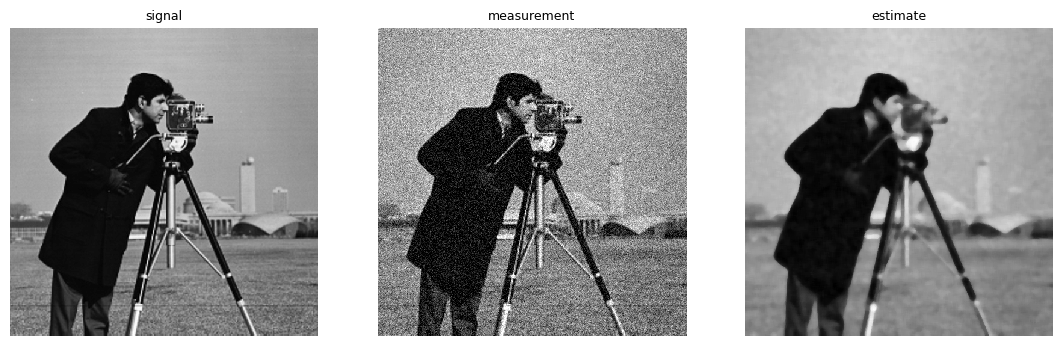

In [160]:
import deepinv as dinv
from deepinv.utils import load_url_image
from deepinv.physics import Denoising, GaussianNoise

url = ("https://huggingface.co/datasets/deepinv/images/resolve/main/cameraman.png?download=true")
x = load_url_image(url=url, img_size=512, grayscale=True, device='cpu')

physics = Denoising(GaussianNoise(sigma=0.1))

data_fidelity = dinv.optim.data_fidelity.L2()
prior = dinv.optim.prior.PnP(denoiser=dinv.models.MedianFilter())
model = dinv.optim.optim_builder(iteration="HQS", prior=prior, data_fidelity=data_fidelity, \
                                 params_algo={"stepsize": 1.0, "g_param": 0.1})
y = physics(x)
x_hat = model(y, physics)
dinv.utils.plot([x, y, x_hat], ["signal", "measurement", "estimate"], rescale_mode='clip',figsize=(14, 4))

In [146]:
import numpy as np
#import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
import deepinv as dinv
from deepinv.utils import load_url_image
from deepinv.physics import Denoising, GaussianNoise

# Charger l'image
url = "https://huggingface.co/datasets/deepinv/images/resolve/main/cameraman.png?download=true"
original_image = load_url_image(url=url, img_size=512, grayscale=True, device='cpu')
# Méthode 2 : Débruitage avec Deep Inverse
def deep_inverse_denoising(original_image):
    physics = Denoising(GaussianNoise(sigma=0.1))
    data_fidelity = dinv.optim.data_fidelity.L2()
    prior = dinv.optim.prior.PnP(denoiser=dinv.models.MedianFilter())
    model = dinv.optim.optim_builder(iteration="HQS", prior=prior, data_fidelity=data_fidelity, \
                                     params_algo={"stepsize": 1.0, "g_param": 0.1})
    noisy_image = physics(original_image)
    denoised_image = model(noisy_image, physics)
    return original_image, noisy_image, denoised_image

# Calculer le PSNR
import numpy as np

def calculate_psnr1(original, denoised):
    original_np = original.cpu().numpy()
    denoised_np = denoised.cpu().numpy()
    return psnr(original_np, denoised_np, data_range=255)
def calculate_psnr(original, denoised):
    """Calcule le PSNR entre l'image originale et l'image débruitée."""
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100  # Pas de bruit
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Afficher les résultats
denoised_image_fista, tab, tab2=FFB(add_gaussian_noise(Im, 45), h = 0.5, prox = proxF5, tau = 0.01, K=100, conv_crit = conv_crit)
original_image, noisy_image, denoised_image_deep = deep_inverse_denoising(original_image)

psnr_fista = calculate_psnr(Im, denoised_image_fista)
psnr_deep = calculate_psnr1(original_image, denoised_image_deep)

100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Temps de calcul FISTA : 47.72198677062988 s


In [148]:
print(f"PSNR FISTA: {psnr_fista:.2f} dB")
print(f"PSNR Deep Inverse: {psnr_deep:.2f} dB")

PSNR FISTA: 24.51 dB
PSNR Deep Inverse: 72.99 dB


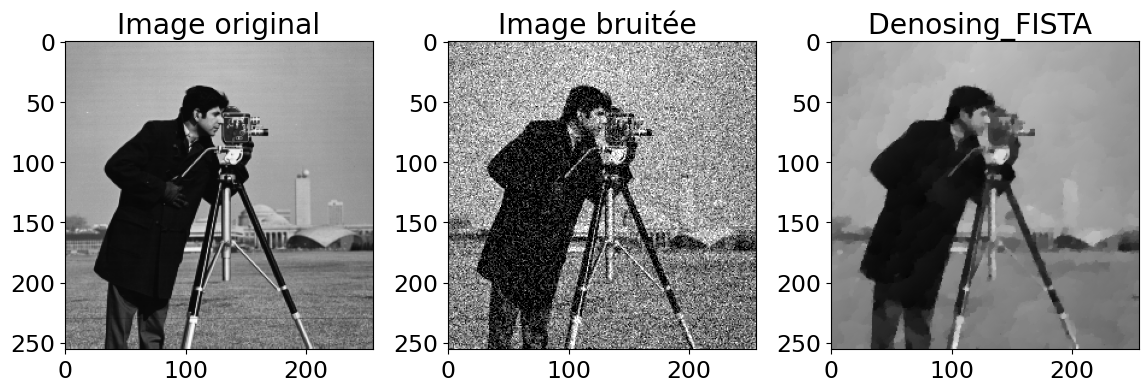

In [150]:
bounds = {'vmin': 0, 'vmax': 255}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].set_title("Image original")
axes[0].imshow(Im, cmap='gray', **bounds)

axes[1].set_title("Image bruitée ")
axes[1].imshow(add_gaussian_noise(Im, 45) ,cmap='gray', **bounds)

axes[2].set_title("Denosing_FISTA ")
axes[2].imshow(denoised_image_fista, cmap='gray', **bounds)

plt.show()

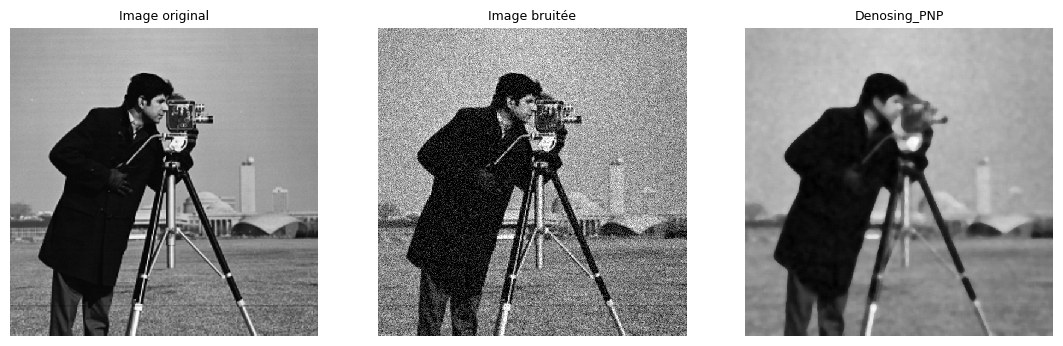

In [152]:
dinv.utils.plot([original_image, noisy_image, denoised_image_deep], ["Image original", "Image bruitée", "Denosing_PNP"], rescale_mode='clip',figsize=(14, 4))